#Load Dataset
The model is set to use the default LCP MWE dataset. To use a different dataset, uncomment the respective code section.

In [ ]:
%%capture
!pip install transformers #==4.0.0rc1
!pip install torch #==1.7.1
!pip install sentencepiece

In [ ]:
import torch
torch.manual_seed(5)
import random
random.seed(0)
import torch.nn as nn
import torch.nn.functional as F
import transformers
import os
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
from scipy import stats
from sklearn.metrics import mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import time

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

class TransformerModel(nn.Module):
  def __init__(self, model_name, max_len, all_layer_train):
     super(TransformerModel, self).__init__()

     self.device = 'cuda'
     self.max_len = max_len
     self.all_layer_train = all_layer_train
     self.hidden = 256
     self.fc1_out = 512
     self.model_name = model_name


     # Loading pretrained transformers model.
     if model_name == "bert":
       self.tf_model = transformers.BertModel.from_pretrained("bert-base-uncased")
       print("Bert model Loading......")
     elif model_name == "roberta":
       self.tf_model = transformers.RobertaModel.from_pretrained("roberta-base")
       print("RoBerta model Loading......")
     elif model_name == "albert":
       self.tf_model = transformers.AlbertModel.from_pretrained('albert-base-v2')
       print("AlBert model Loading......")
     elif model_name == "xlnet":
       self.tf_model = transformers.XLNetModel.from_pretrained('xlnet-base-cased')
       print("XLNet model Loading......")
     elif model_name == "distilbert":
       self.tf_model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
       print("Distilbert model Loading......")

     self.tf_model_drop = nn.Dropout(0.5)
     #  print("ok 1")

     self.bi_lstm = nn.LSTM(768,self.hidden,2, bidirectional= True).to(self.device)
     self.max_pool = nn.MaxPool1d(2,).to(self.device)
     self.fc1 = nn.Linear(self.max_len*self.hidden, self.fc1_out).to(self.device)
     self.tf_model_drop2 = nn.Dropout(0.2).to(self.device)
     self.fc2 = nn.Linear(self.fc1_out, 1).to(self.device)
     self.act1 = nn.ReLU(inplace=True).to(self.device)
     self.act2 = nn.Sigmoid().to(self.device)


  def forward(self, ids, mask, token_type_ids):
      # self.tf_model.trainable = self.all_layer_train
      lin_input = len(ids)
      if self.model_name not in ["distilbert","xlnet"]:
        sequence_output = self.tf_model(ids,attention_mask=mask,token_type_ids=token_type_ids)
        sequence_output = sequence_output[0]
        # pooled_output = None
      elif self.model_name in ["xlnet",]:
        sequence_output = self.tf_model(ids,attention_mask=mask,token_type_ids=token_type_ids)
        sequence_output = sequence_output[0]
        # pooled_output = None
      else:
        sequence_output = self.tf_model(ids,attention_mask=mask)
        sequence_output = sequence_output[0]
        # pooled_output = None
      # print("seq = ",sequence_output.shape)
      # print(sequence_output.device)

      h0 = torch.randn(4,self.max_len,self.hidden).to(self.device)
      c0 = torch.randn(4,self.max_len,self.hidden).to(self.device)
      bi_lstm, (hn, cn) = self.bi_lstm(sequence_output,(h0,c0))
      # print("bi_lstm = ",bi_lstm.shape)

      max_pool = self.max_pool(bi_lstm)
      # print("max_pool = ",max_pool.shape)
      dropout = self.tf_model_drop(max_pool)
      # print("ok 2")
      # print(dropout.shape)

      dropout = dropout.view(lin_input,-1)  #here first get the batch size others will calculate automatically
      # print("cross_check", dropout.shape)

      dense = self.fc1(dropout)
      # print("dense -1", dense.shape)
      act = self.act1(dense)
      dropout2 = self.tf_model_drop2(act)
      dense2 = self.fc2(dropout2)
      outputs = self.act2(dense2)

      return outputs#, pooled_output



# check = TransformerModel('bert',max_len=128, batch_size=8, all_layer_train=False)
# print(check)

class TransformerDataset:
    def __init__(self, text_a, text_b, labels, tokenizer, max_length,model_name):
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model_name = model_name
        self.nolabel = True

    def __len__(self):
        return len(self.text_a)

    def __getitem__(self, idx):
        text_a = str(self.text_a[idx])
        text_b = str(self.text_b[idx])
        if self.labels != None:
          labels = float(self.labels[idx])
        else:
          labels = None
          self.nolabel = False


        text_a = " ".join(text_a.split())
        text_b = " ".join(text_b.split())

        inputs = self.tokenizer.encode_plus(
            text_a,
            text_b,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation = True,
            # pad_to_max_length = True,
            # return_attention_mask = True,   # Construct attn. masks.
            # return_tensors = 'pt',
        )
        ids = inputs["input_ids"]
        if self.model_name not in ["roberta","distilbert"]:
          token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        padding_length = self.max_length - len(ids)

        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        if self.model_name not in ["roberta","distilbert"]:
          token_type_ids = token_type_ids + ([0] * padding_length)
        if self.model_name not in ["roberta","distilbert"]:
          if self.nolabel:
            return {
              'ids': torch.tensor(ids, dtype=torch.int64),
              'mask': torch.tensor(mask, dtype=torch.int64),
              'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
              'targets': torch.tensor(labels, dtype=torch.float),
              # 'label': self.nolabel
          }
          else:
            return {
              'ids': torch.tensor(ids, dtype=torch.int64),
              'mask': torch.tensor(mask, dtype=torch.int64),
              'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
              # 'targets': torch.tensor(labels),
              # 'label': self.nolabel
          }

        else:
          if self.nolabel:
            return {
              'ids': torch.tensor(ids, dtype=torch.int64),
              'mask': torch.tensor(mask, dtype=torch.int64),
              # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
              'targets': torch.tensor(labels, dtype=torch.float),
              # 'label': self.nolabel
          }
          else:
            return {
              'ids': torch.tensor(ids, dtype=torch.int64),
              'mask': torch.tensor(mask, dtype=torch.int64),
              # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
              # 'targets': torch.tensor(labels),
              # 'label': self.nolabel
          }

def loss_fn(outputs,targets):
  # return nn.BCEWithLogitsLoss()(outputs,targets)
  return nn.MSELoss()(outputs,targets)

def train_fn(data_loader, model, optimizer, device, model_name,scheduler = None):
  model.train()
  # targets = torch.tensor(targets, dtype=torch.float)
  # # print("target_shape = ",targets.shape)
  # targets = targets.to(device, dtype= torch.float)
  train_loss = []
  # pooled_outputs = []

  for bi, d in enumerate(data_loader):
    ids = d['ids']
    mask = d['mask']
    if model_name not in ["roberta","distilbert"]:
      token_type_ids = d['token_type_ids']
      token_type_ids = token_type_ids.to(device, dtype= torch.int64)

    b_targets = d['targets']


    ids = ids.to(device, dtype= torch.int64)
    mask = mask.to(device, dtype= torch.int64)
    b_targets = b_targets.to(device, dtype= torch.float)


    optimizer.zero_grad()

    if model_name not in ["roberta","distilbert","xlnet"]:
      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    elif model_name in ["xlnet",]:
      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      # outputs = outputs[0]
    else:
      outputs = model(ids=ids, mask=mask, token_type_ids=None)
    # if model_name not in ["distilbert","xlnet"]:
    #   # pooled_outputs.append(pooled_output.cpu().detach().numpy())
    outputs = torch.flatten(outputs)
    # print("out: ",outputs.shape)
    # print("out: ",outputs)
    # print("b_targets: ",b_targets.shape)
    # print("b_targets: ",b_targets)
    # outputs = outputs.view(target_len)
    loss = loss_fn(outputs, b_targets)


    loss.backward()
    optimizer.step()
    train_loss.append(loss.cpu().data.item())
    if scheduler is not None:
      scheduler.step()
  if model_name not in ["distilbert","xlnet"]:
    return np.mean(train_loss)#, np.vstack(pooled_outputs)
  return np.mean(train_loss)#, pooled_outputs

def eval_fn(data_loader, model, model_name,device):
  model.eval()
  # targets = torch.tensor(targets, dtype=torch.float)
  # # print("target_shape = ",targets.shape)
  # targets = targets.to(device, dtype= torch.float)
  fin_targets = np.array([])
  fin_outputs = np.array([])
  eval_loss = []


  for bi, d in enumerate(data_loader):
    ids = d['ids']
    mask = d['mask']

    if model_name not in ["roberta","distilbert"]:
      token_type_ids = d['token_type_ids']
      token_type_ids = token_type_ids.to(device, dtype= torch.int64)

    b_targets = d['targets']


    ids = ids.to(device, dtype= torch.int64)
    mask = mask.to(device, dtype= torch.int64)
    b_targets = b_targets.to(device, dtype= torch.float)


    if model_name not in ["roberta","distilbert"]:
      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    # elif model_name in ["xlnet",]:
    #   outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    else:
      outputs = model(ids=ids, mask=mask, token_type_ids=None)
    outputs = torch.flatten(outputs)
    # print("out: ",outputs.shape)
    # outputs = outputs.view(target_len2)

    loss = loss_fn(outputs, b_targets)
    eval_loss.append(loss.cpu().data.item())
    # print("outputs = ",outputs)
    # print("targets = ",b_targets)
    # print("Loss = ",loss)

    b_targets = b_targets.cpu().detach().numpy().flatten()
    fin_targets = np.append(fin_targets,b_targets)


    outputs = outputs.cpu().detach().numpy().flatten()
    # print("b_targets: ", len(b_targets))
    # print("outputs: ", len(outputs))


    fin_outputs = np.append(fin_outputs,outputs)
    # print("fin_targets: ", len(fin_targets))
    # print("fin_outputs: ", len(fin_outputs))


  print("Evaluation loss: ", np.mean(eval_loss))
  # print("fin_targets: ", len(fin_targets))
  # print("fin_outputs: ", len(fin_outputs))
  return fin_targets, fin_outputs, np.mean(eval_loss)


def eval_fn2(data_loader, model, model_name,device):
  model.eval()
  # targets = torch.tensor(targets, dtype=torch.float)
  # # print("target_shape = ",targets.shape)
  # targets = targets.to(device, dtype= torch.float)
  fin_targets = np.array([])
  fin_outputs = np.array([])
  eval_loss = []


  for bi, d in enumerate(data_loader):
    ids = d['ids']
    mask = d['mask']

    if model_name not in ["roberta","distilbert"]:
      token_type_ids = d['token_type_ids']
      token_type_ids = token_type_ids.to(device, dtype= torch.int64)



    ids = ids.to(device, dtype= torch.int64)
    mask = mask.to(device, dtype= torch.int64)



    if model_name not in ["roberta","distilbert"]:
      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    # elif model_name in ["xlnet",]:
    #   outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    else:
      outputs = model(ids=ids, mask=mask, token_type_ids=None)
    outputs = torch.flatten(outputs)
    # print("out: ",outputs.shape)
    # outputs = outputs.view(target_len2)


    outputs = outputs.cpu().detach().numpy().flatten()
    # print("b_targets: ", len(b_targets))
    # print("outputs: ", len(outputs))


    fin_outputs = np.append(fin_outputs,outputs)
    # print("fin_targets: ", len(fin_targets))
    # print("fin_outputs: ", len(fin_outputs))



  # print("fin_targets: ", len(fin_targets))
  # print("fin_outputs: ", len(fin_outputs))
  return fin_outputs




##########################################################################
#########  LCP SWI Dataset Loading #######################################
##########################################################################
# print("Loading Single token dataset....")

# def fixed(df1):
#   ls = ['3NQUW096N688UWPZIKJTM3DK0YZ9LZ','30ZKOOGW2W6998V0HGFAYJFQ8ACA19','3VP28W7DUNK10VXG07AU4EATI52FZG']
#   for i in range(len(df1)):
#     if df1['id'].values[i] in ls:
#       df1.token.values[i]='null'
#       # print(df1.values[i])
#   return df1

# import pandas as pd
# import numpy as np
# # Preparing train data
# path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/train/lcp_single_train_1.tsv'
# # path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/train/data_preprocessed/train.tsv'
# dp = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/trial/lcp_single_trial.tsv'
# # tp = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/train/data_preprocessed/test.tsv'
# TrialFileLocation = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/test-labels/lcp_single_test.tsv'


# train_data = pd.read_table(path, sep='\t+',header=0, engine='python')
# valid_data = pd.read_table(dp, sep='\t+',header=0, engine='python')
# test_data = pd.read_table(TrialFileLocation, sep='\t+',header=0, engine='python')
# df1 = pd.DataFrame(train_data)
# # df1 = fixed(df1)
# valid_df = pd.DataFrame(valid_data)
# test_df = pd.DataFrame(test_data)


# df =  pd.concat([df1.reset_index(drop=True),
#                 valid_df.reset_index(drop=True)],
#                 axis=0, join='outer', ignore_index=True)
# print(np.array(df[:2]))


# train_df = df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'})
# eval_df = valid_df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'}).dropna()
# test_df = test_df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'}).dropna()

# print(len(train_df))
# print(len(eval_df))
# print(len(test_df))
# print(train_df.columns)
# # print(eval_df.columns)
# print(train_df.tail())

########################################################################
#########  LCP MWE Dataset Loading #######################################
#######################################################################
print("Loading Multi-Token dataset.....")
import pandas as pd
import numpy as np
# Preparing train data
# path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/data_model_multi/train.tsv'
path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/train/lcp_multi_train_1.tsv'
dp = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/trial/lcp_multi_trial.tsv'
TrialFileLocation = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/test-labels/lcp_multi_test.tsv'

# WN_path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/CWI2018-English/WikiNews_final_train.tsv'
# N_path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/CWI2018-English/News_final_train.tsv'
# WP_path = '/content/drive/MyDrive/Colab Notebooks/workshop/semeval2021Task1/Dataset/CWI2018-English/Wikipedia_final_train.tsv'


train_data = pd.read_table(path, sep='\t+',header=0, engine='python')
valid_data = pd.read_table(dp, sep='\t+',header=0, engine='python')
test_data = pd.read_table(TrialFileLocation, sep='\t+',header=0, engine='python')

# train_data1 = pd.read_table(WN_path, sep='\t+',header=0, engine='python')
# train_data2 = pd.read_table(N_path, sep='\t+',header=0, engine='python')
# train_data3 = pd.read_table(WP_path, sep='\t+',header=0, engine='python')

df1 = pd.DataFrame(train_data)
# df2 = pd.DataFrame(train_data1)
# df2 = get_multi_data(df2)
# df3 = pd.DataFrame(train_data2)
# df3 = get_multi_data(df3)
# df4 = pd.DataFrame(train_data3)
# df4 = get_multi_data(df4)

# del df1['corpus']
# del df2['binary_label']
# del df3['binary_label']
# del df4['binary_label']
# print(df1.columns)
# print(df2.columns)
# print(df3.columns)
# print(df4.columns)
# df =  pd.concat([df1,df2,df3,df4], axis=0, join='outer', ignore_index=True)

valid_df = pd.DataFrame(valid_data)
valid_df.columns = ['id', 'corpus', 'sentence', 'token', 'complexity']
test_df = pd.DataFrame(test_data)
df =  pd.concat([df1,valid_df], axis=0, join='outer', ignore_index=True)


train_df = df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'}).dropna()
eval_df = valid_df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'}).dropna()
test_df = test_df.rename(columns={'sentence': 'text_a', 'token': 'text_b', 'complexity': 'labels'}).dropna()

print(len(train_df))
print(len(eval_df))
print(len(test_df))
print(train_df.columns)
# print(eval_df.columns)
print(train_df.tail())




def run(model_name, max_len, batch_size,epoch,learning_rate):
  MAX_LEN = max_len
  TRAIN_BATCH_SIZE = batch_size
  EPOCHS = epoch
  if model_name == "bert":
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    print("Bert tokenizer Loading......")
  elif model_name== "roberta":
    tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
    print("RoBert tokenizer Loading......")
  elif model_name== "albert":
    tokenizer = transformers.AlbertTokenizer.from_pretrained('albert-base-v2')
    print("AlBert tokenizer Loading......")
  elif model_name== "distilbert":
    tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    print("Distilbert tokenizer Loading......")
  elif model_name== "xlnet":
    tokenizer = transformers.AutoTokenizer.from_pretrained('xlnet-base-cased')#XLNetTokenizer
    print("Xlnet tokenizer Loading......")
  # train_targets = list(train_df.labels.values)
  # test_targets = list(test_df.labels.values)

  # target_len = len(train_targets)
  # target_len2 = len(test_targets)

  train_dataset = TransformerDataset(
      text_a = list(train_df.text_a.values),
      text_b = list(train_df.text_b.values),
      labels = list(train_df.labels.values),
      tokenizer = tokenizer,
      max_length = MAX_LEN,
      model_name = model_name
  )

  train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        drop_last=True
    )
  valid_dataset = TransformerDataset(
      text_a = list(test_df.text_a.values),
      text_b = list(test_df.text_b.values),
      labels = list(test_df.labels.values),
      tokenizer = tokenizer,
      max_length = MAX_LEN,
      model_name = model_name
  )

  valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )
  device = 'cuda'
  lr = learning_rate
  num_train_steps = int(len(train_dataset)/ TRAIN_BATCH_SIZE * EPOCHS)
  model = TransformerModel(model_name=model_name, max_len=MAX_LEN, all_layer_train=False).to(device)
  optimizer = AdamW(model.parameters(),lr = lr)

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps = 0,
      num_training_steps = num_train_steps

  )

  path = model_name+"_best_model_v2.pth"
  loss_train = []
  loss_val = []
  epochs = range(EPOCHS)
  best_loss = 100000
  best_pearson = -10000
  # os.makedirs(path,exist_ok=True)
  # final_pooled_outputs = []
  start_time = time.time()
  for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader,model,optimizer,device,model_name = model_name,scheduler=scheduler)
    print("Training loss after EPOCH {}: {}".format(epoch+1,train_loss))
    loss_train.append(train_loss)
    torch.cuda.empty_cache()
    # print(len(pooled_outputs[0]))
    # print(pooled_outputs[:5])
    eval_targets,eval_output,eval_loss = eval_fn(valid_dataloader,model,model_name,device)

    loss_val.append(eval_loss)
    eval_output = eval_output.flatten()
    eval_targets = eval_targets.flatten()

    coef, _ = stats.spearmanr(eval_output,eval_targets)
    coef1, _1 = stats.pearsonr(eval_output,eval_targets)
    print("epochs = {}, spearman = {}".format(epoch+1,coef))
    print("epochs = {}, pearson = {}".format(epoch+1,coef1))
    # print(coef.shape)

    # if eval_loss < best_loss: #model save on the basis of best loss
    if coef1 > best_pearson:   #model save on the basis of Pearson score
        torch.save({
            "model_state_dict" :model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }, path)
        # best_loss = eval_loss
        best_pearson = coef1
        # final_pooled_outputs = pooled_outputs
  # torch.cuda.empty_cache()
  end_time = time.time()
  total_time = end_time - start_time
  training_time = total_time
  print('{} Training complete in {:.0f}m {:.0f}s'.format(model_name, training_time // 60, training_time % 60))
  print("Best Pearson Score = ",best_pearson)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print("\nFINISH :) \n")
  # return final_pooled_outputs



Loading Multi-Token dataset.....
1616
99
184
Index(['id', 'corpus', 'text_a', 'text_b', 'labels'], dtype='object')
                                  id    corpus  \
1611  382GHPVPHSRQHMTYVJJ2998NEMF348  europarl   
1612  3FVBZG9CLJEOC6IWR3L210JKGFHH0D  europarl   
1613  32CXT5U14G3BZHTJM65GDUESTLV8US  europarl   
1614  30ZKOOGW2W6998V0HGFAYJFQ8CXA1Y  europarl   
1615  3QO7EE372ON29MK9895LUV74Y6ABQP  europarl   

                                                 text_a  \
1611  'The Council considers transparency as a princ...   
1612  It is not an easy task, particularly for the c...   
1613  However, the Turkish proposal is nothing more ...   
1614  This is entirely in line with international co...   
1615  It fills me with consternation that the questi...   

                           text_b    labels  
1611         paramount importance  0.465909  
1612     protectionist tendencies  0.500000  
1613        provocative manoeuvre  0.532609  
1614      international consensus  0.590909  

#Model Training

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Xlnet tokenizer Loading......


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

XLNet model Loading......
Training loss after EPOCH 1: 0.023867004036921824
Evaluation loss:  0.027450444703192814
epochs = 1, spearman = 0.1772160197071959
epochs = 1, pearson = 0.2279534455007336
Training loss after EPOCH 2: 0.018713314320182077
Evaluation loss:  0.012446821647007828
epochs = 2, spearman = 0.7051111715392397
epochs = 2, pearson = 0.7076024488498973
Training loss after EPOCH 3: 0.01107939698394517
Evaluation loss:  0.010229579557705185
epochs = 3, spearman = 0.7709980056505089
epochs = 3, pearson = 0.7731510385398445
Training loss after EPOCH 4: 0.007889012832627955
Evaluation loss:  0.009464061970863006
epochs = 4, spearman = 0.751337626343633
epochs = 4, pearson = 0.7854621276671728
Training loss after EPOCH 5: 0.005925159706874741
Evaluation loss:  0.009455029847626776
epochs = 5, spearman = 0.7735179249188471
epochs = 5, pearson = 0.8064679164528488
Training loss after EPOCH 6: 0.004748506609253622
Evaluation loss:  0.008630232829803033
epochs = 6, spearman = 0.79

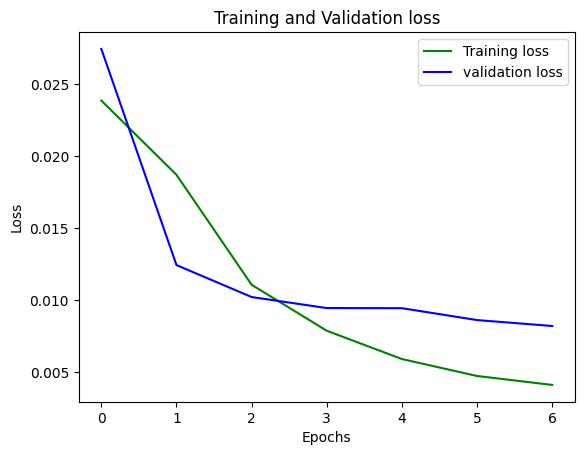


FINISH :) 



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Distilbert tokenizer Loading......


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Distilbert model Loading......


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 1: 0.02384960161070201
Evaluation loss:  0.019555614522212873
epochs = 1, spearman = 0.37746194379796777
epochs = 1, pearson = 0.46239838764739505


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 2: 0.01818595419748511
Evaluation loss:  0.01210018552576556
epochs = 2, spearman = 0.7824118142936823
epochs = 2, pearson = 0.7694123230939799


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 3: 0.011251464308905739
Evaluation loss:  0.008998829005893482
epochs = 3, spearman = 0.8009885127225456
epochs = 3, pearson = 0.8075272949163635


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 4: 0.006918686437466652
Evaluation loss:  0.008325036994748465
epochs = 4, spearman = 0.806273985591572
epochs = 4, pearson = 0.8254717932806087


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 5: 0.005148370941008193


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Evaluation loss:  0.008993865172986103
epochs = 5, spearman = 0.7793148951622955
epochs = 5, pearson = 0.7965468844001857


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 6: 0.0038654984644669486
Evaluation loss:  0.008480240621239594
epochs = 6, spearman = 0.7997179570975693
epochs = 6, pearson = 0.8122565666216888


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 7: 0.0031769770408789214
Evaluation loss:  0.008202016211884178
epochs = 7, spearman = 0.7945268848739164
epochs = 7, pearson = 0.8131293036910834


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 8: 0.0025334899768459213
Evaluation loss:  0.00835906613982566
epochs = 8, spearman = 0.8036442533275949
epochs = 8, pearson = 0.8115483079107495


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 9: 0.002065264060862805
Evaluation loss:  0.008492058436588748
epochs = 9, spearman = 0.7991293979718219
epochs = 9, pearson = 0.8097423584828769


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training loss after EPOCH 10: 0.0018989836177148967
Evaluation loss:  0.008804313797989616
epochs = 10, spearman = 0.7910754816864329
epochs = 10, pearson = 0.8009208163596718
distilbert Training complete in 5m 20s
Best Pearson Score =  0.8254717932806087


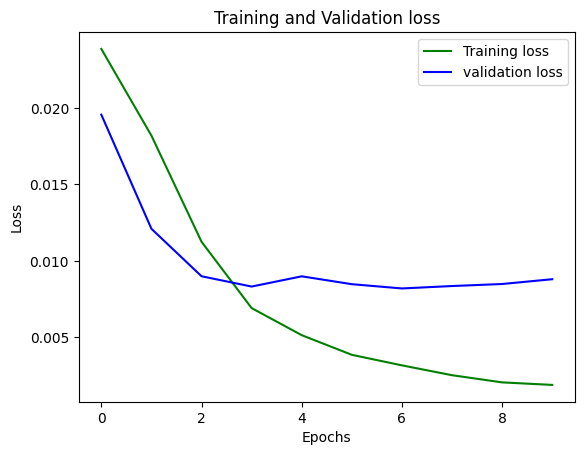


FINISH :) 



In [ ]:

# #Run for BERT model
bert_pooled_output= run(
                        model_name = 'bert',
                        max_len = 128,
                        batch_size = 16,
                        epoch = 5,
                        learning_rate = 2.8e-5,
                    )

print("BERT batch size = {}\nlearning rate = {}".format(16,2.8e-5))

# # Run for RoBERTa model

roberta_pooled_output= run(
                        model_name = 'roberta',
                        max_len = 128,
                        batch_size = 16,
                        epoch = 10,
                        learning_rate = 3e-5
                    )



print("RoBERTa batch size = {}\nlearning rate = {}".format(16,3e-5))
# # Run for AlBERT model
# albert_pooled_output= run(
#                         model_name = 'roberta',
#                         max_len = 128,
#                         batch_size = 8,
#                         epoch = 10,
#                         learning_rate = 2.55e-5
#                     )
# print("batch size = {}\nlearning rate = {}".format(8,2.55e-5))
# Run for XLNet model

xlnet_pooled_output= run(
                        model_name = 'xlnet',
                        max_len = 128,
                        batch_size = 8,
                        epoch = 7,
                        learning_rate = 2.8e-5
                    )

print("XLNet batch size = {}\nlearning rate = {}".format(8,2.8e-5))
# Run for DistilBERT model

distilbert_pooled_output= run(
                        model_name = 'distilbert',
                        max_len = 128,
                        batch_size =8,
                        epoch = 10,
                        learning_rate = 2.5e-5
                    )
print("DistilBERT batch size = {}\nlearning rate = {}".format(8,2.5e-5))

#Evaluation

In [ ]:
# # print(bert_pooled_output[:5])
# # print(roberta_pooled_output[:5])

# torch.cuda.empty_cache()

#Save model loading and get prediction
MAX_LEN = 128
batch_size = 8
batch_size2 = 8
batch_size3 = 16
batch_size4 = 8
batch_size5 = 16
model_name = "bert"
model_name2 = "roberta"
model_name3 = "albert"
model_name4 = "xlnet"
model_name5 = "distilbert"



# #for BERT
# model = TransformerModel('bert', max_len=128, all_layer_train=False).to("cuda")
# optimizer = AdamW(model.parameters(),lr = 2.8e-5)
# checkpoint = torch.load("bert_best_model_v2.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# #For Roberta
# model2 = TransformerModel('roberta', max_len=128, all_layer_train=False).to("cuda")
# optimizer2 = AdamW(model2.parameters(),lr = 3e-5)
# checkpoint2 = torch.load("roberta_best_model_v2.pth")
# model2.load_state_dict(checkpoint2['model_state_dict'])
# optimizer2.load_state_dict(checkpoint2['optimizer_state_dict'])

# # # #For AlBERT
# # # model3 = TransformerModel('albert', max_len=128, all_layer_train=False).to("cuda")
# # # optimizer3 = AdamW(model3.parameters(),lr = 3e-5)
# # # checkpoint3 = torch.load("albert_best_model_v2.pth")
# # # model3.load_state_dict(checkpoint3['model_state_dict'])
# # # optimizer3.load_state_dict(checkpoint3['optimizer_state_dict'])

# #For XLNet
# model4 = TransformerModel('xlnet', max_len=128, all_layer_train=False).to("cuda")
# optimizer4 = AdamW(model4.parameters(),lr = 2.8e-5)
# checkpoint4 = torch.load("xlnet_best_model_v2.pth")
# model4.load_state_dict(checkpoint4['model_state_dict'])
# optimizer4.load_state_dict(checkpoint4['optimizer_state_dict'])

# #For DistilBERT
# model5 = TransformerModel('distilbert', max_len=128, all_layer_train=False).to("cuda")
# optimizer5 = AdamW(model5.parameters(),lr = 2.5e-5)
# checkpoint5 = torch.load("distilbert_best_model_v2.pth")
# model5.load_state_dict(checkpoint5['model_state_dict'])
# optimizer5.load_state_dict(checkpoint5['optimizer_state_dict'])

# print(model)


tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer2 = transformers.RobertaTokenizer.from_pretrained('roberta-base')
# # tokenizer3 = transformers.AlbertTokenizer.from_pretrained('albert-base-v2')
tokenizer4 = transformers.AutoTokenizer.from_pretrained('xlnet-base-cased')
tokenizer5 = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


test_dataset = TransformerDataset(
      text_a = list(eval_df.text_a.values),
      text_b = list(eval_df.text_b.values),
      labels = list(eval_df.labels.values),
      tokenizer = tokenizer,
      max_length = MAX_LEN,
      model_name= model_name
  )

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

####For Roberta ####
test_dataset2 = TransformerDataset(
      text_a = list(eval_df.text_a.values),
      text_b = list(eval_df.text_b.values),
      labels = list(eval_df.labels.values),
      tokenizer = tokenizer2,
      max_length = MAX_LEN,
      model_name= model_name2
  )

test_dataloader2 = torch.utils.data.DataLoader(
        test_dataset2,
        batch_size=batch_size2,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )


# # ####For albert ####
# # test_dataset3 = TransformerDataset(
# #       text_a = list(test_df.text_a.values),
# #       text_b = list(test_df.text_b.values),
# #       labels = list(test_df.labels.values),
# #       tokenizer = tokenizer3,
# #       max_length = MAX_LEN,
# #       model_name= model_name3
# #   )

# # test_dataloader3 = torch.utils.data.DataLoader(
# #         test_dataset3,
# #         batch_size=batch_size3,
# #         shuffle= False,
# #         num_workers=0,
# #         drop_last=True
# #     )

####For xlnet ####
test_dataset4 = TransformerDataset(
      text_a = list(eval_df.text_a.values),
      text_b = list(eval_df.text_b.values),
      labels = list(eval_df.labels.values),
      tokenizer = tokenizer4,
      max_length = MAX_LEN,
      model_name= model_name4
  )

test_dataloader4 = torch.utils.data.DataLoader(
        test_dataset4,
        batch_size=batch_size4,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

####For distilbert ####
test_dataset5 = TransformerDataset(
      text_a = list(eval_df.text_a.values),
      text_b = list(eval_df.text_b.values),
      labels = list(eval_df.labels.values),
      tokenizer = tokenizer5,
      max_length = MAX_LEN,
      model_name= model_name5
  )

test_dataloader5 = torch.utils.data.DataLoader(
        test_dataset5,
        batch_size=batch_size5,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

device = 'cuda'

eval_targets,bert_preds,bert_loss = eval_fn(test_dataloader,model,model_name,device)
eval_targets,roberta_preds,roberta_loss = eval_fn(test_dataloader2,model2,model_name2,device)
# # eval_targets3,albert_preds,albert_loss = eval_fn(test_dataloader3,model3,model_name3,device)
eval_targets,xlnet_preds,xlnet_loss = eval_fn(test_dataloader4,model4,model_name4,device)
eval_targets5,distilbert_preds,distilbert_loss = eval_fn(test_dataloader5,model5,model_name5,device)


bert_preds = bert_preds.flatten()
eval_targets = eval_targets.flatten()
roberta_preds = roberta_preds.flatten()
# # albert_preds = albert_preds.flatten()
xlnet_preds = xlnet_preds.flatten()
distilbert_preds = distilbert_preds.flatten()

coef, _ = stats.pearsonr(bert_preds,eval_targets)
coef2, _ = stats.pearsonr(roberta_preds,eval_targets)
# # coef3, _ = stats.pearsonr(albert_preds,eval_targets)
coef4, _ = stats.pearsonr(xlnet_preds,eval_targets)
coef5, _ = stats.pearsonr(distilbert_preds,eval_targets)

coefs, _ = stats.spearmanr(bert_preds,eval_targets)
coefs2, _ = stats.spearmanr(roberta_preds,eval_targets)
coefs4, _ = stats.spearmanr(xlnet_preds,eval_targets)
coefs5, _ = stats.spearmanr(distilbert_preds,eval_targets)


print("BERT model pearson = {}".format(coef))
print("BERT model spearman = {}".format(coefs))
print('BERT mean absolute error',mean_absolute_error(bert_preds,eval_targets))
print('BERT mean squared error',mean_squared_error(bert_preds,eval_targets))
print('BERT rsquared R2',rsquared(bert_preds,eval_targets))

print("RoBERTa model pearson = {}".format(coef2))
print("RoBERTa model spearman = {}".format(coefs2))
print('RoBERTa mean absolute error',mean_absolute_error(roberta_preds,eval_targets))
print('RoBERTa mean squared error',mean_squared_error(roberta_preds,eval_targets))
print('RoBERTa rsquared R2',rsquared(roberta_preds,eval_targets))



print("XLNet model pearson = {}".format(coef4))
print("XLNet model spearman = {}".format(coefs4))
print('XLNet mean absolute error',mean_absolute_error(xlnet_preds,eval_targets))
print('XLNet mean squared error',mean_squared_error(xlnet_preds,eval_targets))
print('XLNet rsquared R2',rsquared(xlnet_preds,eval_targets))


print("DistilBERT model pearson = {}".format(coef5))
print("DistilBERT model spearman = {}".format(coefs5))
print('DistilBERT mean absolute error',mean_absolute_error(distilbert_preds,eval_targets))
print('DistilBERT mean squared error',mean_squared_error(distilbert_preds,eval_targets))
print('DistilBERT rsquared R2',rsquared(distilbert_preds,eval_targets))











# # print("\n\n checking targets\n")
# # print("BERT targets: ",eval_targets[:-5])
# # print("RoBERTa targets: ",eval_targets2[:-5])



# mean_pred = np.mean([roberta_preds,bert_preds],axis=0)
mean_pred2 = np.mean([roberta_preds,bert_preds,xlnet_preds,distilbert_preds],axis=0)


# coef6, _ = stats.pearsonr(mean_pred,eval_targets)
coef7, _ = stats.pearsonr(mean_pred2,eval_targets)

# print("Mean prediction pearson of bert+roberta = {}".format(coef6))
print("Mean prediction pearson of all = {}".format(coef7))

###########################################################
######  Linear Regression Ensemble ########################
###########################################################

# a = bert_preds
# b = roberta_preds
# # c = albert_preds
# d = xlnet_preds
# e = distilbert_preds
# # d = mean_pred
# import pandas as pd

# # Creating the dataframe
# df = pd.DataFrame({"A":a,
#                    "B":b,
#                   #  "C":c,
#                    "D":d,
#                    "E":e
#                    })
# final_preds = []

# for i in range(len(a)):
#   final_preds.append([df.A.values[i],df.B.values[i],df.D.values[i],df.E.values[i]])

# print(final_preds[:5])
# print(np.array(final_preds).shape)


# # Imports
# import torch.nn as nn
# torch.manual_seed(5)
# # import random
# # random.seed(0)
# # import numpy as np
# # np.random.seed(0)

# # inputs = np.array(final_predsI, dtype='float32')
# # targets = train_df.labels.values[:496]
# inputsT = np.array(final_preds, dtype='float32')
# targetsT = test_df.labels.values
# print("\n\n inputs and target value comparison")
# print(inputsT[:5])
# print(targetsT[:5])

# # inputs = torch.from_numpy(inputs).to(dtype=torch.float32) #for uinf train set
# # targets = torch.from_numpy(targets).to(dtype=torch.float32)
# inputsT = torch.from_numpy(inputsT).to(dtype=torch.float32)
# targetsT = torch.from_numpy(targetsT).to(dtype=torch.float32)
# type(inputsT)

# # Import tensor dataset & data loader
# from torch.utils.data import TensorDataset, DataLoader
# # Define dataset
# train_ds = TensorDataset(inputsT, targetsT)
# train_ds[0:3]

# # Define data loader
# batch_size = 16
# train_dl = DataLoader(train_ds, batch_size, shuffle=True)
# # next(iter(train_dl))

# # Define model
# model = nn.Linear(5, 1)
# # model = nn.LazyLinear(1)
# # print(model.weight)
# # print(model.bias)
# # Define optimizer
# opt = torch.optim.AdamW(model.parameters(), lr=2.99e-5)
# # opt = torch.optim.SGD(model.parameters(), lr=2.99e-5)
# # opt = torch.optim.Adagrad(model.parameters(), lr=2.99e-5)

# # Import nn.functional
# import torch.nn.functional as F
# # Define loss function
# loss_fn =F.smooth_l1_loss# F.l1_loss #F.mse_loss

# loss = loss_fn(model(inputsT), targetsT)
# print("Loss of linear regression model",loss)

# # Define a utility function to train the model
# def fit(num_epochs, model, loss_fn, opt):
#     for epoch in range(num_epochs):
#         for xb,yb in train_dl:
#             # Generate predictions
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             # Perform gradient descent
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#     print('Training loss: ', loss_fn(model(inputsT), targetsT))

# # Train the model for 100 epochs
# fit(100, model, loss_fn, opt)

# # Generate predictions
# preds = model(inputsT)
# print("\n\n compare prediction with targets")
# print("preds: ",preds[-5:])
# # Compare with targets
# print("targets: ",targetsT[-5:])

# preds = preds.flatten().cpu().detach().numpy()
# targetsT = targetsT.cpu().detach().numpy()
# print(preds.shape)
# print(targetsT.shape)
# coef8, _ = stats.pearsonr(preds,targetsT)
# coef9, _ = stats.spearmanr(preds,targetsT)
# print("Linear regression final pearson = {}".format(coef8))
# print("Linear regression final spearmanr = {}".format(coef9))

Evaluation loss:  0.009943806673758306
Evaluation loss:  0.00730242187049813
Evaluation loss:  0.002818921795831277
Evaluation loss:  0.006584087353465813
BERT model pearson = 0.7941011486038368
BERT model spearman = 0.8186355468458355
BERT mean absolute error 0.07792775445815289
BERT mean squared error 0.009446109637451116
BERT rsquared R2 0.6305966342139333
RoBERTa model pearson = 0.8531112370048707
RoBERTa model spearman = 0.8748909971435685
RoBERTa mean absolute error 0.06293051117899442
RoBERTa mean squared error 0.006441502025803234
RoBERTa rsquared R2 0.727798782703981
XLNet model pearson = 0.942835123855449
XLNet model spearman = 0.9630591699057145
XLNet mean absolute error 0.039160643337350906
XLNet mean squared error 0.0028039952427672665
XLNet rsquared R2 0.8889380707755186
DistilBERT model pearson = 0.8906580033132844
DistilBERT model spearman = 0.9009406845505662
DistilBERT mean absolute error 0.06119231571151753
DistilBERT mean squared error 0.005902824485572721
DistilBER

#Blending Ensemble

In [ ]:


# # print(bert_pooled_output[:5])
# # print(roberta_pooled_output[:5])

# torch.cuda.empty_cache()

#Save model loading and get prediction
MAX_LEN = 128
batch_size = 8
batch_size2 = 8
batch_size3 = 16
batch_size4 = 8
batch_size5 = 16
model_name = "bert"
model_name2 = "roberta"
model_name3 = "albert"
model_name4 = "xlnet"
model_name5 = "distilbert"



# #for BERT
# model = TransformerModel('bert', max_len=128, all_layer_train=False).to("cuda")
# optimizer = AdamW(model.parameters(),lr = 2.8e-5)
# checkpoint = torch.load("bert_best_model_v2.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# #For Roberta
# model2 = TransformerModel('roberta', max_len=128, all_layer_train=False).to("cuda")
# optimizer2 = AdamW(model2.parameters(),lr = 3e-5)
# checkpoint2 = torch.load("roberta_best_model_v2.pth")
# model2.load_state_dict(checkpoint2['model_state_dict'])
# optimizer2.load_state_dict(checkpoint2['optimizer_state_dict'])

# # # #For AlBERT
# # # model3 = TransformerModel('albert', max_len=128, all_layer_train=False).to("cuda")
# # # optimizer3 = AdamW(model3.parameters(),lr = 3e-5)
# # # checkpoint3 = torch.load("albert_best_model_v2.pth")
# # # model3.load_state_dict(checkpoint3['model_state_dict'])
# # # optimizer3.load_state_dict(checkpoint3['optimizer_state_dict'])

# #For XLNet
# model4 = TransformerModel('xlnet', max_len=128, all_layer_train=False).to("cuda")
# optimizer4 = AdamW(model4.parameters(),lr = 2.8e-5)
# checkpoint4 = torch.load("xlnet_best_model_v2.pth")
# model4.load_state_dict(checkpoint4['model_state_dict'])
# optimizer4.load_state_dict(checkpoint4['optimizer_state_dict'])

# #For DistilBERT
# model5 = TransformerModel('distilbert', max_len=128, all_layer_train=False).to("cuda")
# optimizer5 = AdamW(model5.parameters(),lr = 2.5e-5)
# checkpoint5 = torch.load("distilbert_best_model_v2.pth")
# model5.load_state_dict(checkpoint5['model_state_dict'])
# optimizer5.load_state_dict(checkpoint5['optimizer_state_dict'])

# print(model)


tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer2 = transformers.RobertaTokenizer.from_pretrained('roberta-base')
# # tokenizer3 = transformers.AlbertTokenizer.from_pretrained('albert-base-v2')
tokenizer4 = transformers.AutoTokenizer.from_pretrained('xlnet-base-cased')
tokenizer5 = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


test_dataset = TransformerDataset(
      text_a = list(test_df.text_a.values),
      text_b = list(test_df.text_b.values),
      labels = list(test_df.labels.values),
      tokenizer = tokenizer,
      max_length = MAX_LEN,
      model_name= model_name
  )

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

####For Roberta ####
test_dataset2 = TransformerDataset(
      text_a = list(test_df.text_a.values),
      text_b = list(test_df.text_b.values),
      labels = list(test_df.labels.values),
      tokenizer = tokenizer2,
      max_length = MAX_LEN,
      model_name= model_name2
  )

test_dataloader2 = torch.utils.data.DataLoader(
        test_dataset2,
        batch_size=batch_size2,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )


# # ####For albert ####
# # test_dataset3 = TransformerDataset(
# #       text_a = list(test_df.text_a.values),
# #       text_b = list(test_df.text_b.values),
# #       labels = list(test_df.labels.values),
# #       tokenizer = tokenizer3,
# #       max_length = MAX_LEN,
# #       model_name= model_name3
# #   )

# # test_dataloader3 = torch.utils.data.DataLoader(
# #         test_dataset3,
# #         batch_size=batch_size3,
# #         shuffle= False,
# #         num_workers=0,
# #         drop_last=True
# #     )

####For xlnet ####
test_dataset4 = TransformerDataset(
      text_a = list(test_df.text_a.values),
      text_b = list(test_df.text_b.values),
      labels = list(test_df.labels.values),
      tokenizer = tokenizer4,
      max_length = MAX_LEN,
      model_name= model_name4
  )

test_dataloader4 = torch.utils.data.DataLoader(
        test_dataset4,
        batch_size=batch_size4,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

####For distilbert ####
test_dataset5 = TransformerDataset(
      text_a = list(test_df.text_a.values),
      text_b = list(test_df.text_b.values),
      labels = list(test_df.labels.values),
      tokenizer = tokenizer5,
      max_length = MAX_LEN,
      model_name= model_name5
  )

test_dataloader5 = torch.utils.data.DataLoader(
        test_dataset5,
        batch_size=batch_size5,
        shuffle= False,
        num_workers=0,
        # drop_last=True
    )

device = 'cuda'

eval_targets,bert_preds1,bert_loss = eval_fn(test_dataloader,model,model_name,device)
eval_targets,roberta_preds1,roberta_loss = eval_fn(test_dataloader2,model2,model_name2,device)
# # eval_targets3,albert_preds,albert_loss = eval_fn(test_dataloader3,model3,model_name3,device)
eval_targets,xlnet_preds1,xlnet_loss = eval_fn(test_dataloader4,model4,model_name4,device)
eval_targets5,distilbert_preds1,distilbert_loss = eval_fn(test_dataloader5,model5,model_name5,device)


bert_preds1 = bert_preds1.flatten()
eval_targets = eval_targets.flatten()
roberta_preds1 = roberta_preds1.flatten()
# # albert_preds = albert_preds.flatten()
xlnet_preds1 = xlnet_preds1.flatten()
distilbert_preds1 = distilbert_preds1.flatten()

coef, _ = stats.pearsonr(bert_preds1,eval_targets)
coef2, _ = stats.pearsonr(roberta_preds1,eval_targets)
# # coef3, _ = stats.pearsonr(albert_preds,eval_targets)
coef4, _ = stats.pearsonr(xlnet_preds1,eval_targets)
coef5, _ = stats.pearsonr(distilbert_preds1,eval_targets)

coefs, _ = stats.spearmanr(bert_preds1,eval_targets)
coefs2, _ = stats.spearmanr(roberta_preds1,eval_targets)
coefs4, _ = stats.spearmanr(xlnet_preds1,eval_targets)
coefs5, _ = stats.spearmanr(distilbert_preds1,eval_targets)


print("BERT model pearson = {}".format(coef))
print("BERT model spearman = {}".format(coefs))
print('BERT mean absolute error',mean_absolute_error(bert_preds1,eval_targets))
print('BERT mean squared error',mean_squared_error(bert_preds1,eval_targets))
print('BERT rsquared R2',rsquared(bert_preds1,eval_targets))

print("RoBERTa model pearson = {}".format(coef2))
print("RoBERTa model spearman = {}".format(coefs2))
print('RoBERTa mean absolute error',mean_absolute_error(roberta_preds1,eval_targets))
print('RoBERTa mean squared error',mean_squared_error(roberta_preds1,eval_targets))
print('RoBERTa rsquared R2',rsquared(roberta_preds1,eval_targets))



print("XLNet model pearson = {}".format(coef4))
print("XLNet model spearman = {}".format(coefs4))
print('XLNet mean absolute error',mean_absolute_error(xlnet_preds1,eval_targets))
print('XLNet mean squared error',mean_squared_error(xlnet_preds1,eval_targets))
print('XLNet rsquared R2',rsquared(xlnet_preds1,eval_targets))


print("DistilBERT model pearson = {}".format(coef5))
print("DistilBERT model spearman = {}".format(coefs5))
print('DistilBERT mean absolute error',mean_absolute_error(distilbert_preds1,eval_targets))
print('DistilBERT mean squared error',mean_squared_error(distilbert_preds1,eval_targets))
print('DistilBERT rsquared R2',rsquared(distilbert_preds1,eval_targets))











# # print("\n\n checking targets\n")
# # print("BERT targets: ",eval_targets[:-5])
# # print("RoBERTa targets: ",eval_targets2[:-5])



# mean_pred = np.mean([roberta_preds,bert_preds],axis=0)
# mean_pred2 = np.mean([roberta_preds,bert_preds,xlnet_preds,distilbert_preds],axis=0)


# coef6, _ = stats.pearsonr(mean_pred,eval_targets)
# coef7, _ = stats.pearsonr(mean_pred2,eval_targets)

# print("Mean prediction pearson of bert+roberta = {}".format(coef6))
# print("Mean prediction pearson of all = {}".format(coef7))


# a = bert_preds
# b = roberta_preds
# # c = albert_preds
# d = xlnet_preds
# e = distilbert_preds
# # d = mean_pred
# import pandas as pd

# # Creating the dataframe
# df = pd.DataFrame({"A":a,
#                    "B":b,
#                   #  "C":c,
#                    "D":d,
#                    "E":e
#                    })
# final_preds = []

# for i in range(len(a)):
#   final_preds.append([df.A.values[i],df.B.values[i],df.D.values[i],df.E.values[i]])

# print(final_preds[:5])
# print(np.array(final_preds).shape)


# # Imports
# import torch.nn as nn
# torch.manual_seed(5)
# # import random
# # random.seed(0)
# # import numpy as np
# # np.random.seed(0)

# # inputs = np.array(final_predsI, dtype='float32')
# # targets = train_df.labels.values[:496]
# inputsT = np.array(final_preds, dtype='float32')
# targetsT = test_df.labels.values
# print("\n\n inputs and target value comparison")
# print(inputsT[:5])
# print(targetsT[:5])

# # inputs = torch.from_numpy(inputs).to(dtype=torch.float32) #for uinf train set
# # targets = torch.from_numpy(targets).to(dtype=torch.float32)
# inputsT = torch.from_numpy(inputsT).to(dtype=torch.float32)
# targetsT = torch.from_numpy(targetsT).to(dtype=torch.float32)
# type(inputsT)

# # Import tensor dataset & data loader
# from torch.utils.data import TensorDataset, DataLoader
# # Define dataset
# train_ds = TensorDataset(inputsT, targetsT)
# train_ds[0:3]

# # Define data loader
# batch_size = 16
# train_dl = DataLoader(train_ds, batch_size, shuffle=True)
# # next(iter(train_dl))

# # Define model
# model = nn.Linear(5, 1)
# # model = nn.LazyLinear(1)
# # print(model.weight)
# # print(model.bias)
# # Define optimizer
# opt = torch.optim.AdamW(model.parameters(), lr=2.99e-5)
# # opt = torch.optim.SGD(model.parameters(), lr=2.99e-5)
# # opt = torch.optim.Adagrad(model.parameters(), lr=2.99e-5)

# # Import nn.functional
# import torch.nn.functional as F
# # Define loss function
# loss_fn =F.smooth_l1_loss# F.l1_loss #F.mse_loss

# loss = loss_fn(model(inputsT), targetsT)
# print("Loss of linear regression model",loss)

# # Define a utility function to train the model
# def fit(num_epochs, model, loss_fn, opt):
#     for epoch in range(num_epochs):
#         for xb,yb in train_dl:
#             # Generate predictions
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             # Perform gradient descent
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#     print('Training loss: ', loss_fn(model(inputsT), targetsT))

# # Train the model for 100 epochs
# fit(100, model, loss_fn, opt)

# # Generate predictions
# preds = model(inputsT)
# print("\n\n compare prediction with targets")
# print("preds: ",preds[-5:])
# # Compare with targets
# print("targets: ",targetsT[-5:])

# preds = preds.flatten().cpu().detach().numpy()
# targetsT = targetsT.cpu().detach().numpy()
# print(preds.shape)
# print(targetsT.shape)
# coef8, _ = stats.pearsonr(preds,targetsT)
# coef9, _ = stats.spearmanr(preds,targetsT)
# print("Linear regression final pearson = {}".format(coef8))
# print("Linear regression final spearmanr = {}".format(coef9))

Evaluation loss:  0.008027740997140822
Evaluation loss:  0.007725028781746717
Evaluation loss:  0.008285366302437109
Evaluation loss:  0.009661924831258753
BERT model pearson = 0.8314914002102918
BERT model spearman = 0.8526545638986158
BERT mean absolute error 0.06967267032672206
BERT mean squared error 0.008027741106218093
BERT rsquared R2 0.691377948623672
RoBERTa model pearson = 0.8374251468785767
RoBERTa model spearman = 0.8290014226011961
RoBERTa mean absolute error 0.06980257419585857
RoBERTa mean squared error 0.007725028765683872
RoBERTa rsquared R2 0.7012808766246064
XLNet model pearson = 0.8208437954777397
XLNet model spearman = 0.7948929281927117
XLNet mean absolute error 0.07068160430366255
XLNet mean squared error 0.008285366223116243
XLNet rsquared R2 0.6737845365743006
DistilBERT model pearson = 0.819410246564839
DistilBERT model spearman = 0.7956866642313627
DistilBERT mean absolute error 0.07816604859924511
DistilBERT mean squared error 0.009217041526248972
DistilBERT

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
val_pred1=pd.DataFrame(bert_preds)
test_pred1=pd.DataFrame(bert_preds1)

val_pred2=pd.DataFrame(roberta_preds)
test_pred2=pd.DataFrame(roberta_preds1)

val_pred3=pd.DataFrame(xlnet_preds)
test_pred3=pd.DataFrame(xlnet_preds1)

val_pred4=pd.DataFrame(distilbert_preds)
test_pred4=pd.DataFrame(distilbert_preds1)

df_val=pd.concat([ val_pred1,val_pred2,val_pred3,val_pred4],axis=1)
df_test=pd.concat([test_pred1,test_pred2,test_pred3,test_pred4],axis=1)

y_val = list(eval_df['labels'][:])
y_test = list(test_df['labels'][:])

# model = LogisticRegression()
# model.fit(df_val,y_val)
# model.score(df_test,y_test)


import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    # linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()
    ]

trainingData    = df_val
trainingScores  = y_val
predictionData  = df_test

for item in classifiers:
    print(item)
    clf = item
    clf.fit(trainingData, trainingScores)
    preds = clf.predict(predictionData)
    coef, _ = stats.pearsonr(preds,eval_targets)
    coefs, _ = stats.spearmanr(preds,eval_targets)

    print("model pearson = {}".format(coef))
    print(" model spearman = {}".format(coefs))
    print('mean absolute error',mean_absolute_error(preds,eval_targets))
    print('mean squared error',mean_squared_error(preds,eval_targets))
    print('rsquared R2',rsquared(preds,eval_targets))


print('DecisionTreeRegressor\n')
clf = DecisionTreeRegressor()
clf.fit(trainingData, trainingScores)
preds = clf.predict(predictionData)
coef, _ = stats.pearsonr(preds,eval_targets)
coefs, _ = stats.spearmanr(preds,eval_targets)

print("model pearson = {}".format(coef))
print(" model spearman = {}".format(coefs))
print('mean absolute error',mean_absolute_error(preds,eval_targets))
print('mean squared error',mean_squared_error(preds,eval_targets))
print('rsquared R2',rsquared(preds,eval_targets))



SVR()
model pearson = 0.8408876304654119
 model spearman = 0.8242399696411821
mean absolute error 0.07007444147788866
mean squared error 0.00796211750740214
rsquared R2 0.7070920070697344
SGDRegressor()
model pearson = 0.8582439344787882
 model spearman = 0.8498119485466026
mean absolute error 0.08462933629928072
mean squared error 0.011186007512755445
rsquared R2 0.7365826510696307
BayesianRidge()
model pearson = 0.8225554881140732
 model spearman = 0.7997497450699909
mean absolute error 0.06985765948563326
mean squared error 0.00797587934039523
rsquared R2 0.6765975310265807
ARDRegression()
model pearson = 0.8246657518528394
 model spearman = 0.7996900222127139
mean absolute error 0.06933375322981657
mean squared error 0.007903349070874454
rsquared R2 0.6800736022790076
PassiveAggressiveRegressor()
model pearson = 0.8412808612122367
 model spearman = 0.8283165362862922
mean absolute error 0.7325183033417686
mean squared error 0.5618458205470875
rsquared R2 0.7077534874420023
TheilSen